In [168]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [169]:
# set project root and year
project_root = Path.cwd().parents[0]
year = 2022  # change as needed

# define input paths
raw_path = project_root / "data" / "raw" / str(year) / f"masc_{year}.xlsx"
summary_path = project_root / "data" / "reference" / "masc_summary.csv"
aci_path = project_root / "data" / "interim" / str(year) / f"aci_ag_summary_{year}.csv"
imputed_path = project_root / "data" / "interim" / str(year) / f"masc_imputed_{year}.csv"
crop_list_path = project_root / "data" / "reference" / "masc_crop_list.txt"
lut_path = project_root / "data" / "reference" / "crop_label_lut.csv"

# load data
masc_df = pd.read_excel(raw_path, engine="calamine")
summary_df = pd.read_csv(summary_path)
aci_df = pd.read_csv(aci_path)
imputed_df = pd.read_csv(imputed_path)
lut_df = pd.read_csv(lut_path)

# display basic info
print(f"Loaded {len(masc_df)} raw MASC rows for {year}")
print(f"Loaded {len(imputed_df)} imputed MASC rows for {year}")
print(f"Loaded {len(aci_df)} ACI summary rows for {year}")

Loaded 11317 raw MASC rows for 2022
Loaded 11316 imputed MASC rows for 2022
Loaded 29 ACI summary rows for 2022


In [170]:
lut_path = project_root / "data" / "reference" / "crop_label_lut.csv"

lut = pd.read_csv(lut_path)

print("Columns:", lut.columns.tolist())
print("Shape:", lut.shape)
lut.head(10)

Columns: ['Crop', 'Label']
Shape: (124, 2)


,Crop,Label
0,PINTO BEANS,Beans
1,BLACK BEANS,Beans
2,WHITE PEA BEANS,Peas
3,KIDNEY BEANS,Beans
4,OTH DRY EDIBLE BEANS,Beans
5,SMALL RED BEANS,Beans
6,ADZUKI BEANS,Beans
7,CRANBERRY BEANS,Beans
8,FABABEANS,Fababeans
9,FIELD PEAS,Peas


In [171]:
pd.options.display.float_format = '{:,.3f}'.format

In [172]:
imputed_df.head()

,year,rm,crop,variety,farms,acres,yield_per_acre,yield,imputed
0,2022,DAUPHIN,PER. RYEGRASS SEED,NO VAR,3,535.000,0.376,201.160,0
1,2022,NORTH NORFOLK,OIL SUNFLOWERS,CP432E (WINFIELD),4,"2,092.000",0.277,579.484,0
2,2022,NORTH NORFOLK,OIL SUNFLOWERS,P63HE60 (PIONEER) (ET),4,986.000,0.187,184.382,0
3,2022,PORTAGE LA PRAIRIE,PROC POTATOES-IRRIG,INNOVATOR,4,"1,382.000",16.532,"22,847.224",0
4,2022,GLENBORO-SOUTH CYPRESS,PROC POTATOES-IRRIG,RUSSET BURBANK (GEMS),4,"2,332.000",15.452,"36,034.064",0


In [173]:
aci_df.head()

,Label,pixel_count,hectares,acres
0,Canola/rapeseed,17764220,"1,598,779.800","3,950,670.924"
1,Spring wheat,16432114,"1,478,890.260","3,654,417.418"
2,Pasture/forages,6443165,"579,884.850","1,432,926.671"
3,Soybeans,4810335,"432,930.150","1,069,793.699"
4,Oats,3376427,"303,878.430","750,899.954"


In [174]:
# load
with open(crop_list_path) as f:
    masc_crops = [line.strip().upper() for line in f if line.strip()]

lut = pd.read_csv(lut_path)
lut["Crop"] = lut["Crop"].str.strip().str.upper()

# find unmapped crops
unmapped = sorted(set(masc_crops) - set(lut["Crop"]))

print(f"Unmapped crops: {len(unmapped)}")
for c in unmapped:
    print(c)

Unmapped crops: 0


In [175]:
imputed_df.columns.tolist()

['year',
 'rm',
 'crop',
 'variety',
 'farms',
 'acres',
 'yield_per_acre',
 'yield',
 'imputed']

In [176]:
# map MASC crops to ACI labels and compare totals

lut = pd.read_csv(lut_path)

lut["Crop"] = lut["Crop"].str.strip().str.upper()
lut["Label"] = lut["Label"].str.strip().str.lower()
imputed_df["crop"] = imputed_df["crop"].str.strip().str.upper()
aci_df["Label"] = aci_df["Label"].str.strip().str.lower()

# map masc crops to aci labels
masc_mapped = imputed_df.merge(lut, left_on="crop", right_on="Crop", how="left")

# sum MASC by label
masc_sum = masc_mapped.groupby("Label", as_index=False)["acres"].sum()

# sum ACI by label
aci_sum = aci_df.groupby("Label", as_index=False)["acres"].sum()

# merge for comparison
compare = masc_sum.merge(aci_sum, on="Label", how="outer", suffixes=("_masc", "_aci")).fillna(0)

# calculate difference and percent difference
compare["acres_diff"] = compare["acres_aci"] - compare["acres_masc"]
compare["acres_diff_pct"] = np.where(
    compare["acres_masc"] > 0,
    (compare["acres_aci"] - compare["acres_masc"]) / compare["acres_masc"] * 100,
    np.nan
)

print(f"Comparison table for {year}: {len(compare)} labels")
compare.head(50)


Comparison table for 2022: 32 labels


,Label,acres_masc,acres_aci,acres_diff,acres_diff_pct
0,barley,"344,138.889","332,988.018","-11,150.870",-3.240
1,beans,"87,366.846","121,462.500","34,095.655",39.026
2,buckwheat,"4,522.066",666.517,"-3,855.549",-85.261
3,canaryseed,"4,229.731","2,174.354","-2,055.377",-48.594
4,canola/rapeseed,"3,118,934.688","3,950,670.924","831,736.236",26.667
5,corn,"383,418.673","499,479.025","116,060.351",30.270
6,fababeans,940.485,0.000,-940.485,-100.000
7,fallow,0.000,"1,017.456","1,017.456",NaN
8,flaxseed,"50,596.525","38,954.236","-11,642.289",-23.010
9,hemp,"6,606.875","2,479.035","-4,127.840",-62.478


The table above shows a very important consideration for the project. If I'm going to use the aci raster
to localise and differentiate ag residue biomass further than what I can do with just masc data,
then overall the masc totals will be diluted. This is because the aci classifications have either overclassified
agriculture land in Manitoba or masc data is incomplete, perhaps because farmers are not reporting. However,
that is a large discrepancy to not be reporting.

The ACI data is what could be cropped, and this may lead to overestimation. It could also just be misclassification
of imagery.

In [177]:
# total provincial cropland estimates from each source
total_masc = compare["acres_masc"].sum()
total_aci = compare["acres_aci"].sum()

print(f"Total MASC acres: {total_masc:,.0f}")
print(f"Total ACI acres:  {total_aci:,.0f}")
print(f"Difference (ACI - MASC): {total_aci - total_masc:,.0f}")

Total MASC acres: 9,455,541
Total ACI acres:  13,070,690
Difference (ACI - MASC): 3,615,148


From 2024 data:
- ACI is roughly 3.6 million acres higher than both the census and MASC, suggesting systematic over-classification of agricultural pixels (particularly in pasture, hay, or fallow categories).
- MASC under-represents total cropland slightly (~1.6 M ac less than census) because of data suppression and exclusion of smaller holdings or marginal categories.
- The “true” value almost certainly lies between the two — around 11 – 12 million acres, which matches the literature.

We need to dig deeper into the rm data and see if the aci over-classification is randomly across the province or concentrated in certain areas. Perhaps
geographic factors have contributed to the over-classification.

In [178]:
aci_df.columns.tolist()

['Label', 'pixel_count', 'hectares', 'acres']

I'd like to see things as compared yearly.

In [179]:
def compare_masc_aci(year):
    # define paths for the year
    aci_path = project_root / "data" / "interim" / str(year) / f"aci_ag_summary_{year}.csv"
    imputed_path = project_root / "data" / "interim" / str(year) / f"masc_imputed_{year}.csv"
    lut_path = project_root / "data" / "reference" / "crop_label_lut.csv"

    # load data
    imputed_df = pd.read_csv(imputed_path)
    aci_df = pd.read_csv(aci_path)
    lut = pd.read_csv(lut_path)

    # standardize text
    lut["Crop"] = lut["Crop"].str.strip().str.upper()
    lut["Label"] = lut["Label"].str.strip().str.lower()
    imputed_df["crop"] = imputed_df["crop"].str.strip().str.upper()
    aci_df["Label"] = aci_df["Label"].str.strip().str.lower()

    # map crops to labels
    masc_mapped = imputed_df.merge(lut, left_on="crop", right_on="Crop", how="left")

    # aggregate
    masc_sum = masc_mapped.groupby("Label", as_index=False)["acres"].sum()
    aci_sum = aci_df.groupby("Label", as_index=False)["acres"].sum()

    compare = masc_sum.merge(aci_sum, on="Label", how="outer", suffixes=("_masc", "_aci")).fillna(0)
    compare["acres_diff"] = compare["acres_aci"] - compare["acres_masc"]
    compare["acres_diff_pct"] = np.where(
        compare["acres_masc"] > 0,
        (compare["acres_aci"] - compare["acres_masc"]) / compare["acres_masc"] * 100,
        np.nan,
    )
    compare["year"] = year

    # totals for quick reference
    total_masc = compare["acres_masc"].sum()
    total_aci = compare["acres_aci"].sum()
    total_diff = total_aci - total_masc
    print(f"\nYear {year}")
    print(f"Total MASC acres: {total_masc:,.0f}")
    print(f"Total ACI acres:  {total_aci:,.0f}")
    print(f"Difference (ACI - MASC): {total_diff:,.0f}")

    return compare


# run across all years
years = range(2017, 2024)
all_years = [compare_masc_aci(y) for y in years]
compare_all = pd.concat(all_years, ignore_index=True)

# yearly summary
summary = (
    compare_all.groupby("year", as_index=False)
    .agg({
        "acres_masc": "sum",
        "acres_aci": "sum",
        "acres_diff": "sum"
    })
)
summary["acres_diff_pct"] = (summary["acres_diff"] / summary["acres_masc"]) * 100

# save
out_dir = project_root / "data" / "processed"
out_dir.mkdir(parents=True, exist_ok=True)
compare_all.to_csv(out_dir / "masc_aci_compare_by_label.csv", index=False)
summary.to_csv(out_dir / "masc_aci_yearly_summary.csv", index=False)

print(f"\nSaved full comparison: {out_dir / 'masc_aci_compare_by_label.csv'}")
print(f"Saved yearly summary:   {out_dir / 'masc_aci_yearly_summary.csv'}")



Year 2017
Total MASC acres: 9,887,982
Total ACI acres:  11,846,001
Difference (ACI - MASC): 1,958,019

Year 2018
Total MASC acres: 10,006,637
Total ACI acres:  11,776,623
Difference (ACI - MASC): 1,769,986

Year 2019
Total MASC acres: 9,887,805
Total ACI acres:  12,502,893
Difference (ACI - MASC): 2,615,089

Year 2020
Total MASC acres: 9,931,544
Total ACI acres:  13,056,585
Difference (ACI - MASC): 3,125,040

Year 2021
Total MASC acres: 10,339,246
Total ACI acres:  12,738,117
Difference (ACI - MASC): 2,398,870

Year 2022
Total MASC acres: 9,455,541
Total ACI acres:  13,070,690
Difference (ACI - MASC): 3,615,148

Year 2023
Total MASC acres: 10,113,696
Total ACI acres:  13,422,594
Difference (ACI - MASC): 3,308,897

Year 2024
Total MASC acres: 9,945,150
Total ACI acres:  13,578,313
Difference (ACI - MASC): 3,633,163

Saved full comparison: /Users/dpro/projects/biomass/subprojects/mapping/ag_res/data/processed/masc_aci_compare_by_label.csv
Saved yearly summary:   /Users/dpro/projects/bio

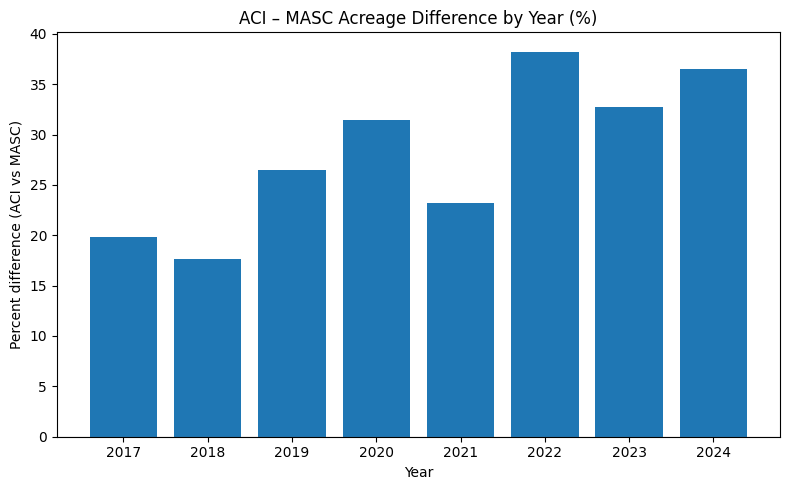

In [180]:
plt.figure(figsize=(8, 5))
plt.bar(summary["year"], summary["acres_diff_pct"], color="tab:blue")
plt.axhline(0, color="gray", linewidth=0.8)
plt.title("ACI – MASC Acreage Difference by Year (%)")
plt.ylabel("Percent difference (ACI vs MASC)")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


It's important to note with the following bar charts that, if a crop is found to have 0 acres in MASC, and non-zero in ACI,
then the percentage is infinite, and therefore calculates to NaN. To see these crops, the chart showing absolute differences
is more reliable and includes all crops.

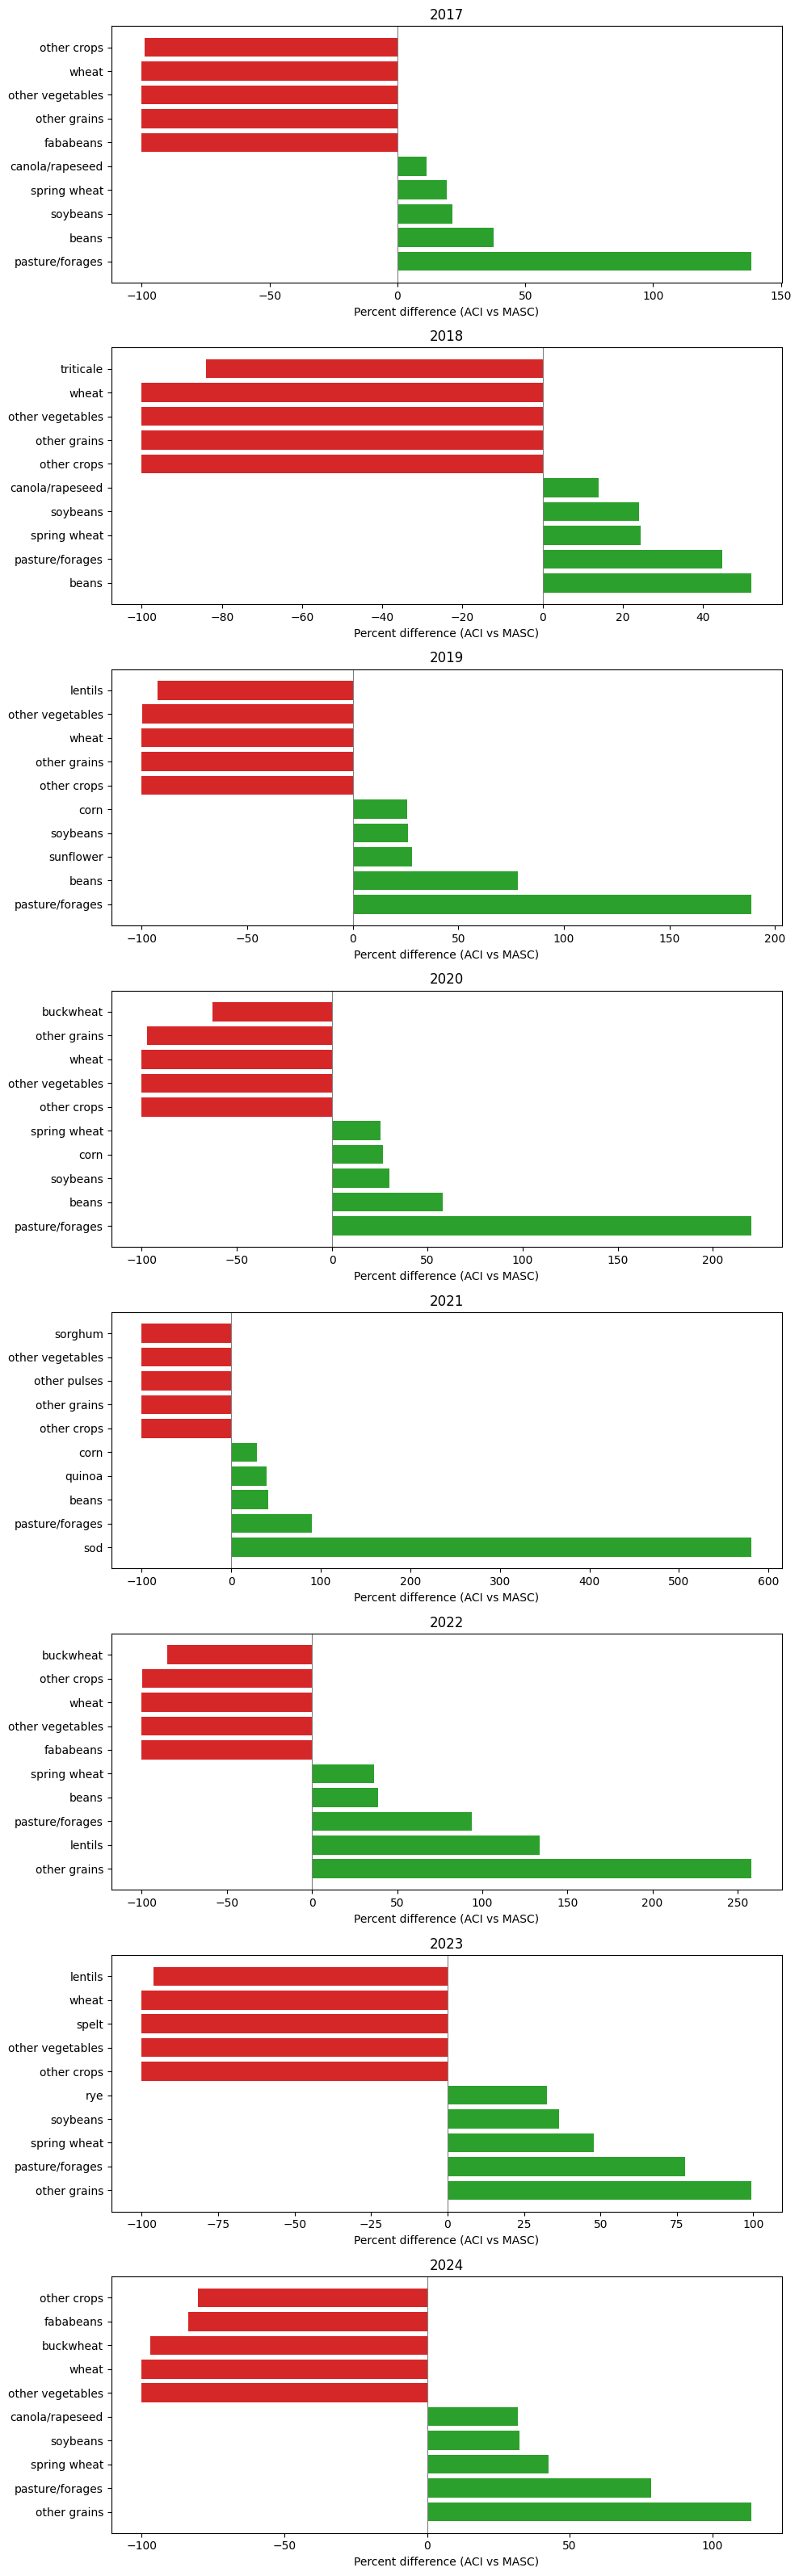

In [181]:
years = sorted(compare_all["year"].unique())
fig, axes = plt.subplots(len(years), 1, figsize=(10, len(years) * 4))

for i, year in enumerate(years):
    df_year = compare_all[compare_all["year"] == year].copy()

    top_over = df_year.nlargest(5, "acres_diff_pct")[["Label", "acres_diff_pct"]]
    top_under = df_year.nsmallest(5, "acres_diff_pct")[["Label", "acres_diff_pct"]]

    ax = axes[i]
    ax.barh(top_over["Label"], top_over["acres_diff_pct"], color="tab:green")
    ax.barh(top_under["Label"], top_under["acres_diff_pct"], color="tab:red")
    ax.axvline(0, color="gray", linewidth=0.8)
    ax.set_title(f"{year}")
    ax.set_xlabel("Percent difference (ACI vs MASC)")

plt.tight_layout()
plt.show()

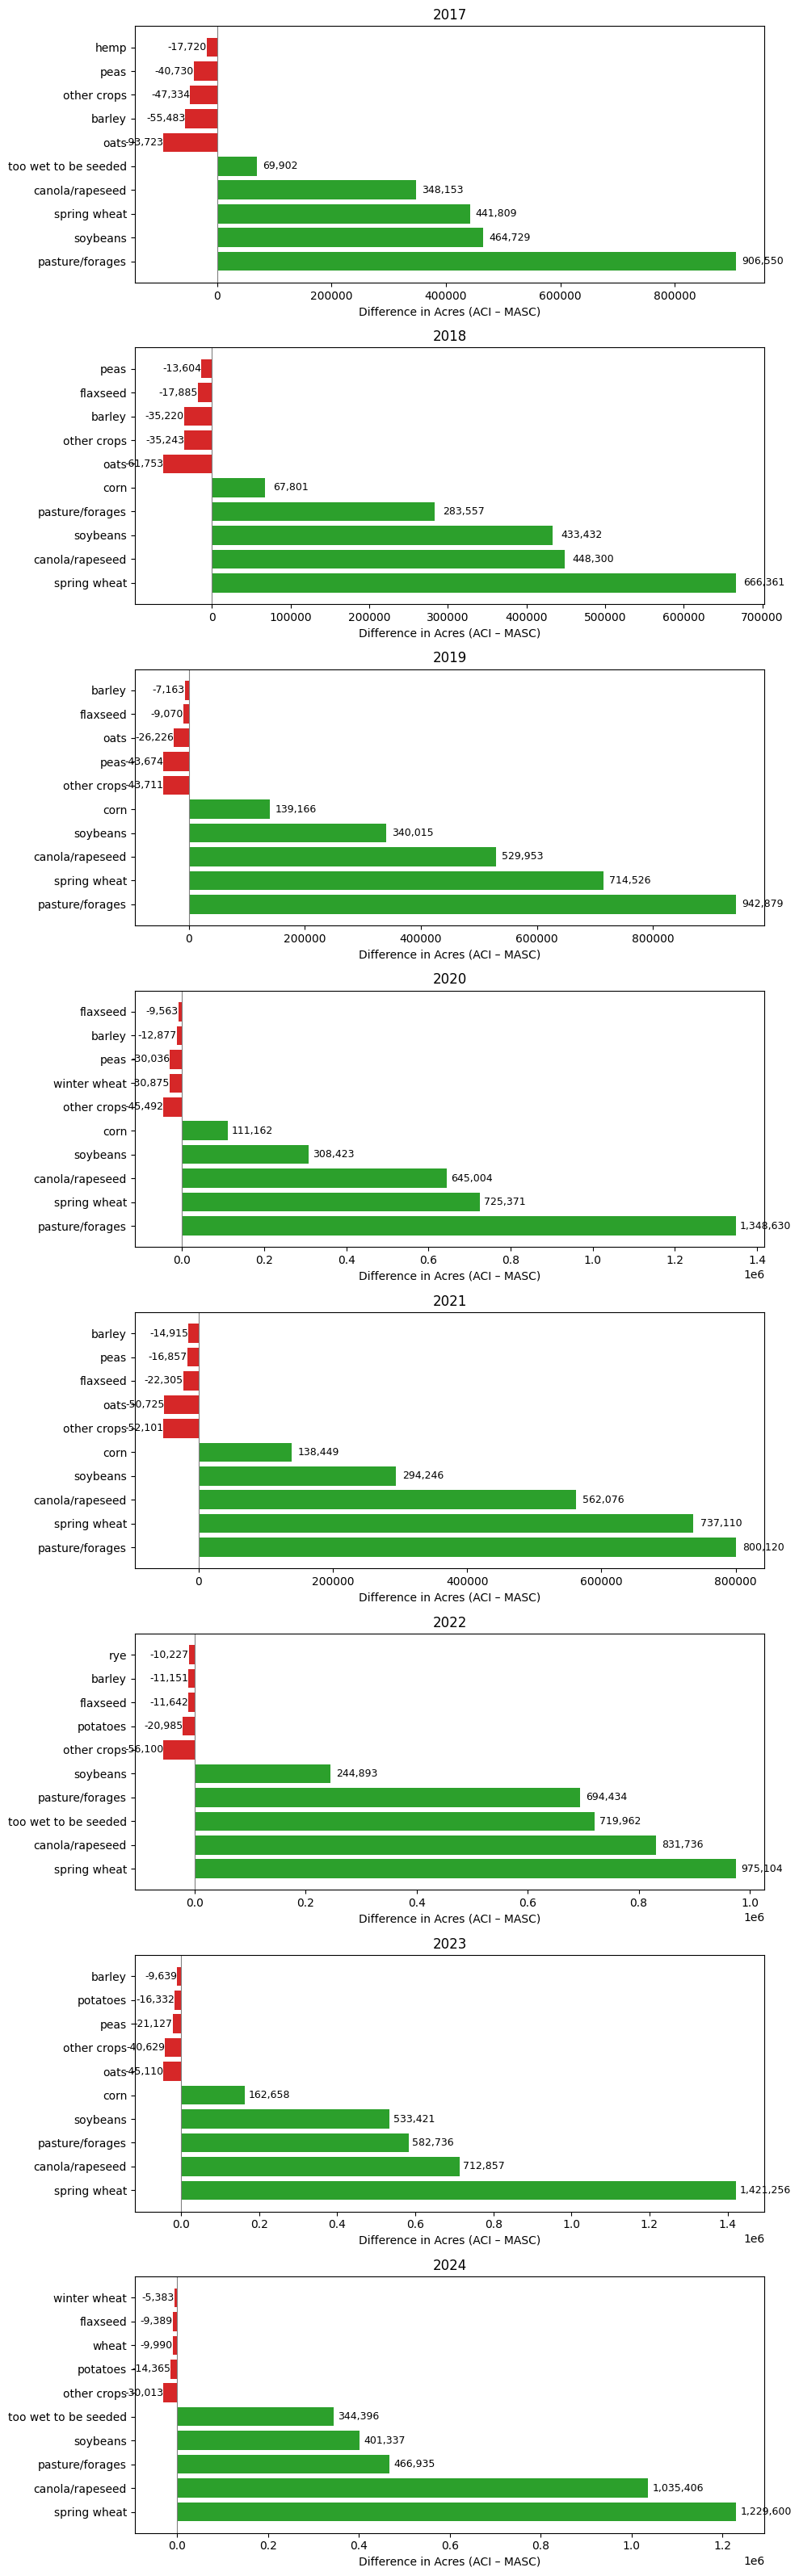

In [182]:
# number of top/bottom crops per year
n = 5
years = sorted(compare_all["year"].unique())
fig, axes = plt.subplots(len(years), 1, figsize=(10, len(years) * 4))

for i, year in enumerate(years):
    df_year = compare_all[compare_all["year"] == year].copy()

    # Top and bottom n by acres_diff
    top_over = df_year.nlargest(n, "acres_diff")[["Label", "acres_diff"]]
    top_under = df_year.nsmallest(n, "acres_diff")[["Label", "acres_diff"]]

    ax = axes[i]
    bars_over = ax.barh(top_over["Label"], top_over["acres_diff"], color="tab:green")
    bars_under = ax.barh(top_under["Label"], top_under["acres_diff"], color="tab:red")
    ax.axvline(0, color="gray", linewidth=0.8)
    ax.set_title(f"{year}")
    ax.set_xlabel("Difference in Acres (ACI – MASC)")

    # Add value labels
    for bar in bars_over + bars_under:
        width = bar.get_width()
        ax.text(
            width + (10000 if width > 0 else -100),  # offset text slightly from bar
            bar.get_y() + bar.get_height() / 2,
            f"{width:,.0f}",
            va="center",
            ha="left" if width > 0 else "right",
            fontsize=9
        )

plt.tight_layout()
plt.show()

Overestimation of ACI acreage as a percentage shows no clear correlation with Manitoba’s largest crops by acreage, as identified in MASC ground-truth reporting. For major crops, the percent difference between MASC and ACI totals is smaller than for minority crops. However, because major crops occupy much larger total areas, even modest proportional errors translate into large absolute differences.

Minority and rare crops, by contrast, exhibit large percentage differences because their total acreages are small. Even minor deviations in ACI classification produce large relative errors.

Overestimation of ACI acreage in absolute terms does correlate strongly with Manitoba’s largest crops. Although the percent difference for these crops is moderate, their large spatial footprint causes substantial total overestimation in ACI data.

This pattern is consistent with training data imbalance (whether through non-stratified or partially stratified sampling), where majority classes dominate the loss function and achieve lower proportional error, while minority classes bear a higher relative cost. In such cases, stratified sampling or class-balanced weighting would help maintain proportional accuracy across all crop types, even if it slightly reduces total accuracy.

Although I can't find any papers that say explicitly whether training was done with random sampling or stratified sampling, better classification of majority crops indicates that stratified
sampling was not used.

Fisette et al. (2013) reported that the 2011 ACI overestimated national agricultural area by about 15 percent compared to the Census of Agriculture. The Manitoba comparison between MASC and ACI for 2024 shows a similar direction of error, with ACI totals exceeding MASC by roughly 27 to 30 percent. This consistency across time indicates a structural bias that is not limited to a specific year. And since imagery techniques and data collection have changed through years with ACI data, this overestimate is not likely due to, for instance, a specific satellite. It likely reflects the broader definition of “agriculture” used in ACI, which includes managed grasslands, fallow, and perennial forage areas that are not always classified as cropland in administrative datasets such as MASC.

To deal with MASC acreage being 0 while ACI acreage is non-zero, we must go by the ground-truth of MASC data and assume those pixels have been
incorrectly labelled. Since there is no way to know which, if any, Label should have been assigned to said pixels instead, combined with the knowledge
that ACI data is overestimating agricultural land, this case leads to removing any code from the pixels, essentially making them non-agricultural.

To deal with MASC acreage being non-zero while ACI acreage is zero, we must still accept ground-truth of MASC and assume that those crops do exist and
ACI did not label 'some' pixels properly. The solution for this is to reallocation the correct amount of pixels from a crop with the largest magnitude difference
in pixel acreage from MASC acreage, and reassign the correct amount of pixels that redistributes the final yield one-to-one. This is more accurate than just taking the
acreage in pixels and giving it to a different crop, since different crops with the same acreage can have different yields, and yield is what we're most interested in.